In [1]:
import subprocess
import pandas as pd
import lavaburst
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# set initial properties for data location
res = 40000
data_location = "matrices/"
armatus_location = "./armatus"
out_location = "yielded/"
noise_values = [4, 8, 12, 16, 20]
sim_values = list(range(1, 6))

In [3]:
armatus_gamma = [i / 2 for i in range(11)]
modularity_gamma = list(range(101))

In [13]:
# run armatus with all gamma values
for gamma in armatus_gamma:
    print(f"\rgamma={gamma} in progress", end="")
    subprocess.run(f"bash -c '{armatus_location} -i {data_location}simHiC_countMatrix_noise{noise}_sim{sim}.txt.gz -g {gamma} -o {out_location}armatus_gamma{gamma}_noise{noise}_sim{sim} -r {res}'")
print("\rFinished.")

gamma=0.5 in progress

KeyboardInterrupt: 

In [4]:
# convert armatus tad coordinates for further handling
custom_range = [i / 2 for i in range(13)]
for gamma in custom_range:
    tads = pd.read_csv(f"{out_location}armatus_gamma{gamma}_noise{noise}_sim{sim}.txt", comment = "#", sep = "\t", header=None)
    del tads[0]
    tads[2] = tads[2] + 1
    tads.to_csv(f"{out_location}armatus_gamma{gamma}_noise{noise}_sim{sim}.txt", sep="\t", header=None, index=False)
    

In [12]:
#load matrices for lavaburst
matrices = pd.DataFrame(index=noise_values, columns=sim_values)
good_bins = pd.DataFrame(index=noise_values, columns=sim_values)
for noise in noise_values:
    for sim in sim_values:
        print(f"\r noise={noise} sim={sim}", end="")
        matrices.loc[noise, sim] = np.loadtxt(f"{data_location}simHiC_countMatrix_noise{noise}_sim{sim}.txt.gz")
        good_bins.loc[noise, sim] = matrices.loc[noise, sim].astype(bool).sum(axis=0) > 100
print("\r finished")

 finished sim=5


In [15]:
# run lavaburst with modularity score
for noise in noise_values:
    for sim in sim_values:
        for gamma in modularity_gamma:
            print(f"\r noise={noise} sim={sim} gamma={gamma} in progress", end="")
            S = lavaburst.scoring.modularity_score(matrices.loc[noise, sim], gamma=gamma, binmask=good_bins.loc[noise, sim])
            model = lavaburst.SegModel(S)
            segments = model.optimal_segmentation()
            np.savetxt(f"{out_location}lava_modularity_noise{noise}_sim{sim}_gamma{gamma}.txt", segments * res, delimiter="\t", fmt="%d")

 noise=20 sim=5 gamma=100 in progress

In [18]:
#run lavaburst with armatus
for noise in noise_values:
    for sim in sim_values:
        for gamma in armatus_gamma:
            print(f"\rnoise={noise} sim={sim} gamma={gamma} in progress", end="")
            S = lavaburst.scoring.armatus_score(matrices.loc[noise, sim], gamma=gamma, binmask=good_bins.loc[noise, sim])
            model = lavaburst.SegModel(S)
            segments = model.optimal_segmentation()
            np.savetxt(f"{out_location}lava_armatus_noise{noise}_sim{sim}_gamma{gamma}.txt", segments * res, delimiter="\t", fmt="%d")
print("\rFinished.")

Finished.sim=5 gamma=5.0 in progress


Text(0.5,1,'Amount of TADs for lavaburst modularity score')

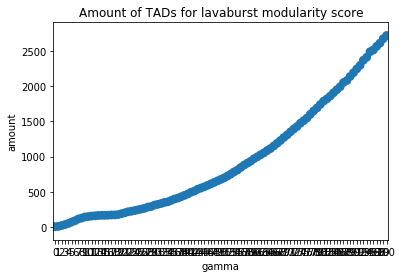

In [20]:
#Estimate TADs amount for lavaburst
lava_lengths = pd.DataFrame(index=range(101), columns=["amount", "gamma"])
for gamma in range(101):
    lava_tads = np.loadtxt(f"{out_location}lava_sim1_{gamma}.txt")
    lava_lengths.loc[gamma, "amount"] = lava_tads.shape[0]
    lava_lengths.loc[gamma, "gamma"] = gamma
sns.pointplot(x="gamma", y="amount", data=lava_lengths)
plt.title("Amount of TADs for lavaburst modularity score")

In [5]:
# make dataframe for TAD amount estimation for armatus
armatus_lengths = pd.DataFrame(index=custom_range, columns=["amount", "gamma"])
for gamma in custom_range:
    armatus_tads = np.loadtxt(f"{out_location}armatus_sim1_{gamma}.txt")
    armatus_lengths.loc[gamma, "amount"] = armatus_tads.shape[0]
    armatus_lengths.loc[gamma, "gamma"] = gamma

Text(0.5,1,'Amount of TADs for armatus')

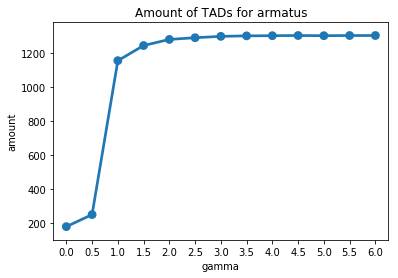

In [19]:
sns.pointplot(x="gamma", y="amount", data=armatus_lengths)
plt.title("Amount of TADs for armatus")

In [16]:
lava_armatus_lengths = pd.DataFrame(index=custom_range, columns=["amount", "gamma"])
for gamma in custom_range:
    lava_armatus_tads = np.loadtxt(f"{out_location}lava_armatus_sim1_{gamma}.txt")
    lava_armatus_lengths.loc[gamma, "amount"] = lava_armatus_tads.shape[0]
    lava_armatus_lengths.loc[gamma, "gamma"] = gamma

Text(0.5,1,'Amount of TADs for lavaburst armatus')

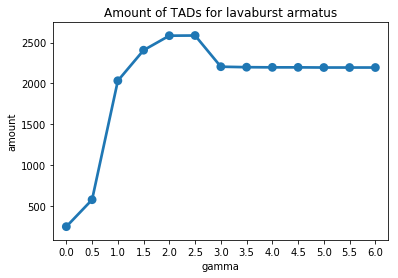

In [18]:
sns.pointplot(x="gamma", y="amount", data=lava_armatus_lengths)
plt.title("Amount of TADs for lavaburst armatus")

In [34]:
# dataframe for TAD length estimation
sizes = pd.DataFrame(index=range(sum(lengths["amount"])), columns = ["sizes", "meth", "gamma"])

In [35]:
start = 0
for gamma in custom_range:
    print(gamma)
    armatus_tads = np.loadtxt(f"{out_location}sim1_{gamma}.consensus.corrected.txt")
    end = armatus_tads.shape[0]
    sizes.loc[start:end + start - 1, "sizes"] = armatus_tads[:,1] - armatus_tads[:,0]
    sizes.loc[start:end + start - 1, "meth"] = "armatus"
    sizes.loc[start:end + start - 1, "gamma"] = gamma
    start += end
    lava_tads = np.loadtxt(f"{out_location}lava_sim1_{gamma}.txt", ndmin=2)
    end = lava_tads.shape[0]
    sizes.loc[start:end + start - 1, "sizes"] = lava_tads[:,1] - lava_tads[:,0]
    sizes.loc[start:end + start - 1, "meth"] = "lava"
    sizes.loc[start:end + start - 1, "gamma"] = gamma
    start += end

0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0


In [38]:
sizes.sizes = pd.to_numeric(sizes.sizes)

C:\Users\Dmitry\Anaconda3\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
C:\Users\Dmitry\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Dmitry\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Dmitry\Anaconda3\lib\site-packages\statsmodels\nonparametric\bandwidths.py:22: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
C:\Users\Dmitry\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


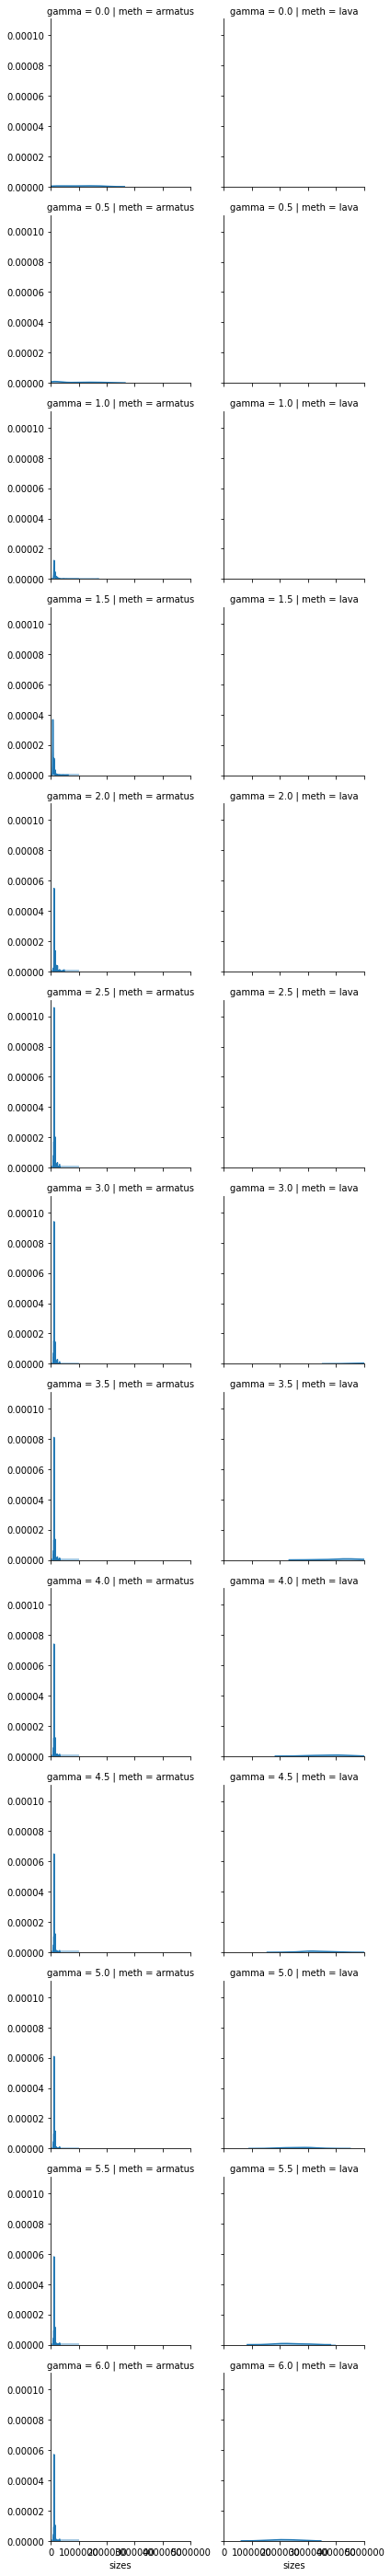

In [50]:
g = sns.FacetGrid(sizes, col="meth", row="gamma", xlim=(0, 0.5*10**7))
g.map(sns.distplot, "sizes", bins=np.arange(0, 10**7, 10**6))
